In [2]:
import numpy as np
import pickle as pk
from google.colab import drive
import tensorflow as tf
import pandas as pd
from keras.datasets import cifar10, cifar100
from tensorflow.keras.layers import Dense , Conv2D, concatenate, MaxPooling2D, UpSampling2D, Input 
from tensorflow.keras.layers import Softmax, Dropout, Flatten,  ReLU, concatenate, BatchNormalization
from tensorflow.keras import Model as Model_ , Sequential
# drive.mount('/content/gdrive', force_remount=True)i

In [3]:
# WRAP THESE ON A FUNCTION or CLASS CALL!
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train/255.
x_test  = x_test / 255.

169009152/169001437 [==============================] - 10s 0us/step


In [6]:
# WRAP THESE ON A FUNCTION or CLASS CALL!
(x_train10, y_train10), (x_test10, y_test10) = cifar10.load_data()
x_train10 = x_train10/255.
x_test10  = x_test10 / 255.

170500096/170498071 [==============================] - 2s 0us/step


# The purpose of the tutorial is to investigate the effect of sharing lattent information of an autoencoder with a simple encoder to increase the classification accuracy
 __I use the Unet architectur this example__
Data set cifar 10 and cifar100 without augomentation 
-Step 1:
  - As baseline:
    - add a global pooling and a FC layer to do the classification on the data sets (BASE)
  - Use the BASE and the unet autoencoder:
    - 

## simple classifier 

In [57]:

class block_conv(tf.keras.layers.Layer):
  def __init__(self, outchannel):
    super(block_conv, self).__init__()  
    self.conv1 = Conv2D(outchannel,3, padding='same')
    self.BN1  = BatchNormalization()
    self.relu1 = ReLU()     
    self.conv2 = Conv2D(outchannel,5, padding='same')
    self.BN2  = BatchNormalization()
    self.relu2 = ReLU() 
  def call(self, x):
    x = self.conv1(x)
    x = self.relu1(self.BN1(x))
    x = self.conv2(x)
    x = self.relu2(self.BN2(x))
    return  x



class BASE(Model_):
  def __init__(self, num_classes=10, drop=True):
    
    super(BASE, self).__init__()
    filter = 64
    self.drop = drop
    self.down_conv1 = block_conv(filter)
    self.maxpool1   = MaxPooling2D((2,2),strides=2)
    self.maxpool2   = MaxPooling2D((2,2),strides=2)
    self.maxpool3   = MaxPooling2D((2,2),strides=2)
    self.down_conv2 = block_conv(2*filter)
    self.down_conv3 = block_conv(4*filter)
    self.z          = block_conv(8*filter)


    # global pooling
    self.avg_pool = tf.keras.layers.GlobalMaxPool2D()
    # self.flat      = tf.keras.layers.Flatten()
    self.classfier = tf.keras.layers.Dense(num_classes, activation='softmax')
    self.dropout1   = Dropout(0.2)
    self.dropout2   = Dropout(0.3)
    self.dropout3   = Dropout(0.4)
  def call(self, input_x):
    dowconv1 = self.down_conv1(input_x)
    max1     = self.maxpool1(dowconv1)
    max1     = self.dropout1(max1)
    dowconv2 = self.down_conv2(max1)
    max2     = self.maxpool2(dowconv2)
    dowconv3 = self.down_conv3(max2)
    max3     = self.maxpool3(dowconv3)
    lattent   = self.z(max3)
   
    if self.drop:
      self.dropout2(lattent)
    avg = self.avg_pool(lattent)
    avg = self.dropout3(avg)
    # x = self.flat(avg)
    cat_out = self.classfier(avg)
   
    return cat_out

# Adding the encoder output to the BASE 

In [33]:
######################### UNET MODEL ###############################################
######## ENCODER PART: 3 X block convolution each follow by Max pooling  ###########
######## DECODER PART: 3 X block convolution each follow by Upsampling ans ######### 
##################### Skip connection ##############################################
####################################################################################

class Decoder(Model_):
  def __init__(self):
   
    super(Decoder, self).__init__()
    filter = 64
    self.upsample1   = UpSampling2D((2,2))
    self.upsample2   = UpSampling2D((2,2))
    self.upsample3   = UpSampling2D((2,2))
    self.up_conv1   = block_conv(4*filter)
    self.up_conv2   = block_conv(2*filter)
    self.up_conv3   = block_conv(filter)
    self.out     = Conv2D(1,kernel_size=1,padding='same')

  
  def call(self, dowconv1, dowconv2, dowconv3, lattent):
     

    upsamp1  = self.upsample1(lattent)
    concat1  = concatenate([dowconv3,upsamp1],axis=3)
    upconv1  = self.up_conv1(concat1)
    upsamp2  = self.upsample2(upconv1)
    concat2  = concatenate([dowconv2,upsamp2],axis=3)
    upconv2  = self.up_conv2(concat2)
    upsamp3  = self.upsample3(upconv2)
    concat3  = concatenate([dowconv1,upsamp3],axis=3)
    upconv3  = self.up_conv3(concat3)
    out      = self.out(upconv3)
    return upconv1, upconv2, upconv3, out 
    
class Encoder_map(Model_):
  """
  Encoder part of the model, 
  """
  def __init__(self, num_classes=10):
    super(Encoder_map, self).__init__()
    filter = 64
    self.down_conv1 = block_conv(filter)
    self.maxpool = MaxPooling2D((2,2),strides=2)
    self.down_conv2 = block_conv(2*filter)
    self.down_conv3 = block_conv(4*filter)
    self.z          = block_conv(8*filter)

  def call(self, input_x):
  
    dowconv1 = self.down_conv1(input_x)
    max1     = self.maxpool(dowconv1)
    dowconv2 = self.down_conv2(max1)
    max2     = self.maxpool(dowconv2)
    dowconv3 = self.down_conv3(max2)
    max3     = self.maxpool(dowconv3)
    lattent   = self.z(max3)
     
    return dowconv1, dowconv2, dowconv3, lattent 




############## Adding the skip connection to the BASE model #######

class Classifer_Encoder(Model_):
  def __init__(self, num_classes=10, drop=True):
    
    super(Classifer_Encoder, self).__init__()
    filter = 64
    self.drop = drop
    self.down_conv1 = block_conv(64)
    self.maxpool1   = MaxPooling2D((2,2),strides=2)
    self.maxpool2   = MaxPooling2D((2,2),strides=2)
    self.maxpool3   = MaxPooling2D((2,2),strides=2)
    self.down_conv2 = block_conv(2*64)
    self.down_conv3 = block_conv(4*64)
    self.z          = block_conv(8*filter)
     
  
    self.encoder_map = Encoder_map()
    self.decoder    = Decoder()
    # global pooling
    self.avg_pool = tf.keras.layers.GlobalMaxPool2D()
    # self.flat      = tf.keras.layers.Flatten()
    self.classfier = tf.keras.layers.Dense(num_classes, activation='softmax')
    self.dropout1   = Dropout(0.3)
    self.dropout2   = Dropout(0.4)
    self.dropout3   = Dropout(0.4)

  def call(self, input_x):

    dow1, dow2, dow3, lat = self.encoder_map(input_x)
    up1, up2, up3, dec_out= self.decoder(dow1, dow2, dow3, lat)
    dowconv1 = self.down_conv1(input_x)
    max1     = self.maxpool1(dowconv1+dow1)
    max1     = self.dropout1(max1)
    dowconv2 = self.down_conv2(max1)
    max2     = self.maxpool2(dowconv2+dow2)
    dowconv3 = self.down_conv3(max2)
    max3     = self.maxpool3(dowconv3+dow3)
    lattent   = self.z(max3)

    if self.drop:
      self.dropout2(lattent)
    avg = self.avg_pool(lattent)
    avg = self.dropout3(avg)
    # x = self.flat(avg)
    cat_out = self.classfier(avg)
   
    return [dec_out, cat_out]

# FULL model 

In [ ]:
class Classifer_(Model_):
  def __init__(self, num_classes=10, drop=True):
    
    super(Classifer_, self).__init__()
    filter = 64
    self.drop = drop
    self.down_conv1 = block_conv(64)
    self.maxpool1   = MaxPooling2D((2,2),strides=2)
    self.maxpool2   = MaxPooling2D((2,2),strides=2)
    self.maxpool3   = MaxPooling2D((2,2),strides=2)
    self.down_conv2 = block_conv(2*64)
    self.down_conv3 = block_conv(4*64)
    self.z          = block_conv(8*filter)
     
   
     
    self.upsample1   = UpSampling2D((2,2))
    self.upsample2   = UpSampling2D((2,2))
    self.upsample3   = UpSampling2D((2,2))
    self.up_conv1   = block_conv(4*filter)
    self.up_conv2   = block_conv(2*filter)
    self.up_conv3   = block_conv(filter)


    self.down_conv1_ = block_conv(64)
    self.maxpool1_   = MaxPooling2D((2,2),strides=2)
    self.maxpool2_   = MaxPooling2D((2,2),strides=2)
    self.maxpool3_   = MaxPooling2D((2,2),strides=2)
    self.down_conv2_ = block_conv(2*64)
    self.down_conv3_ = block_conv(4*64)
    self.z_          = block_conv(8*filter)


    self.encoder_map = Encoder_map()
    self.decoder    = Decoder()
    # global pooling
    self.avg_pool = tf.keras.layers.GlobalMaxPool2D()
    # self.flat      = tf.keras.layers.Flatten()
    self.classfier = tf.keras.layers.Dense(num_classes, activation='softmax')
    self.dropout1   = Dropout(0.2)
    self.dropout2   = Dropout(0.3)
    self.dropout3   = Dropout(0.4)
    self.dropout4   = Dropout(0.4)

  def call(self, input_x):
    dowconv1 = self.down_conv1(input_x)
    max1     = self.maxpool1(dowconv1 )
    max1     = self.dropout1(max1)
    dowconv2 = self.down_conv2(max1)
    max2     = self.maxpool2(dowconv2 )
    dowconv3 = self.down_conv3(max2)
    max3     = self.maxpool3(dowconv3 )
    lattent   = self.z(max3)

    upsamp1  = self.upsample1(lattent)
    upconv1  = self.up_conv1(concatenate([upsamp1, dowconv3], axis=-1))
    upsamp2  = self.upsample2(upconv1)
    upconv2  = self.up_conv2(concatenate([upsamp2, dowconv2],axis=-1))
    upsamp3  = self.upsample3(upconv2)
    upsamp3  = self.dropout2(upsamp3)
    upconv3  = self.up_conv3(concatenate([upsamp3, dowconv1],axis=-1))


    dowconv1_ = self.down_conv1_(upconv3)
    max1_     = self.maxpool1_(dowconv1_+dowconv1)
    dowconv2_ = self.down_conv2(max1_)
    max2_     = self.maxpool2_(dowconv2_+dowconv2)
    dowconv3_ = self.down_conv3(max2_)
    max3_     = self.maxpool3_(dowconv3_+dowconv3)
    max3_     = self.dropout3(max3_)
    lattent_   = self.z_(max3_)

    
    if self.drop:
      self.dropout2(lattent_+lattent)
    avg = self.avg_pool(lattent_)
    avg = self.dropout4(avg)
    # x = self.flat(avg)
    cat_out = self.classfier(avg)
   
    return cat_out


# Full + Unet output as Skip connection 


In [ ]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10, cifar100
from tensorflow.keras.layers import Dense , Conv2D, concatenate, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.layers import Softmax, Dropout, Flatten,  ReLU, concatenate, BatchNormalization
from tensorflow.keras import Model as Model_ , Sequential

from utils import block_conv , Encoder_map, Decoder


class Full_skip(Model_):
    def __init__(self, num_classes=10, drop=True):

        super(Full_skip, self).__init__()
        filter = 64
        self.drop = drop
        self.down_conv1 = block_conv(64)
        self.maxpool1   = MaxPooling2D((2,2),strides=2)
        self.maxpool2   = MaxPooling2D((2,2),strides=2)
        self.maxpool3   = MaxPooling2D((2,2),strides=2)
        self.down_conv2 = block_conv(2*64)
        self.down_conv3 = block_conv(4*64)
        self.z          = block_conv(8*filter)



        self.upsample1   = UpSampling2D((2,2))
        self.upsample2   = UpSampling2D((2,2))
        self.upsample3   = UpSampling2D((2,2))
        self.up_conv1   = block_conv(4*filter)
        self.up_conv2   = block_conv(2*filter)
        self.up_conv3   = block_conv(filter)


        self.down_conv1_ = block_conv(64)
        self.maxpool1_   = MaxPooling2D((2,2),strides=2)
        self.maxpool2_   = MaxPooling2D((2,2),strides=2)
        self.maxpool3_   = MaxPooling2D((2,2),strides=2)
        self.down_conv2_ = block_conv(2*64)
        self.down_conv3_ = block_conv(4*64)
        self.z_          = block_conv(8*filter)


        self.encoder_map = Encoder_map()
        self.decoder    = Decoder()
        # global pooling
        self.avg_pool = tf.keras.layers.GlobalMaxPool2D()
        # self.flat      = tf.keras.layers.Flatten()
        self.classfier = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.dropout1   = Dropout(0.2)
        self.dropout2   = Dropout(0.3)
        self.dropout3   = Dropout(0.4)
        self.dropout4   = Dropout(0.4)

    def call(self, input_x):
        dow1, dow2, dow3, lat = self.encoder_map(input_x)
        up1, up2, up3, dec_out= self.decoder(dow1, dow2, dow3, lat)
        dowconv1 = self.down_conv1(input_x)
        max1     = self.maxpool1(dowconv1+dow1)
        max1     = self.dropout1(max1)
        dowconv2 = self.down_conv2(max1)
        max2     = self.maxpool2(dowconv2+dow2)
        dowconv3 = self.down_conv3(max2)
        max3     = self.maxpool3(dowconv3+dow3)
        lattent   = self.z(max3)

        upsamp1  = self.upsample1(lattent)
        upconv1  = self.up_conv1(concatenate([upsamp1 ,up1], axis=-1))
        upsamp2  = self.upsample2(upconv1)
        upconv2  = self.up_conv2(concatenate([upsamp2, up2],axis=-1))
        upsamp3  = self.upsample3(upconv2)
        upsamp3  = self.dropout2(upsamp3)
        upconv3  = self.up_conv3(concatenate([upsamp3, up3],axis=-1))


        dowconv1_ = self.down_conv1_(upconv3)
        max1_     = self.maxpool1_(dowconv1_+dowconv1)
        dowconv2_ = self.down_conv2(max1_)
        max2_     = self.maxpool2_(dowconv2_+dowconv2)
        dowconv3_ = self.down_conv3(max2_)
        max3_     = self.maxpool3_(dowconv3_+dowconv3)
        max3_     = self.dropout3(max3_)
        lattent_   = self.z_(max3_)


        if self.drop:
          self.dropout2(lattent_+lattent)
        avg = self.avg_pool(lattent_)
        avg = self.dropout4(avg)
        # x = self.flat(avg)
        cat_out = self.classfier(avg)

        return [dec_out, cat_out]

# Plot

In [14]:
BASE_cifar100 = pd.read_csv('/content/gdrive/MyDrive/DLLab/test/BASE_cifar100_2CNN.csv', sep=',', header=None)

In [29]:
BASE_cifar10 = pd.read_csv('/content/gdrive/MyDrive/DLLab/test/BASE_cifar10_2CNN.csv', sep=',', header=None)

In [28]:
FUll_Skip_cifar10 =  pd.read_csv('/content/gdrive/MyDrive/DLLab/test/Full_Encoder_cifar10_2CNN.csv', sep=',', header=None)

In [21]:
FUll_Skip_cifar100 =  pd.read_csv('/content/gdrive/MyDrive/DLLab/test/Full_Encoder_cifar100_2CNN.csv', sep=',', header=None)

In [42]:
FUll_cifar10 =  pd.read_csv('/content/gdrive/MyDrive/DLLab/test/AE_ENC__cifar10_2CNN.csv', sep=',', header=None)

In [38]:
FUll_cifar100 =  pd.read_csv('/content/gdrive/MyDrive/DLLab/test/AE_ENC_2CNN_BLOCK.csv', sep=',', header=None)

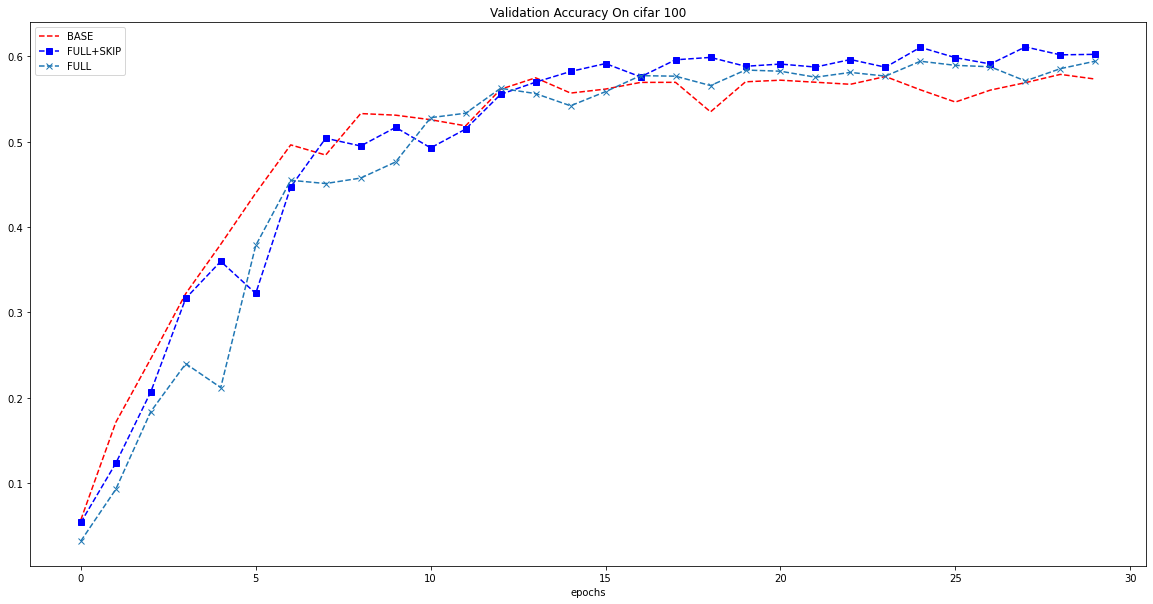

In [45]:
import matplotlib.pyplot as plt 
%matplotlib inline 
fig = plt.figure(figsize=(20,10))
plt.plot(BASE_cifar100.values.squeeze().tolist(), 'r--' )
plt.plot(FUll_Skip_cifar100.values.squeeze().tolist(), 'bs--')
plt.plot(FUll_cifar100.values.squeeze().tolist(), 'x--')
plt.title("Validation Accuracy On cifar 100")
plt.xlabel("epochs")
plt.legend(['BASE', 'FULL+SKIP', 'FULL'], )
plt.show()

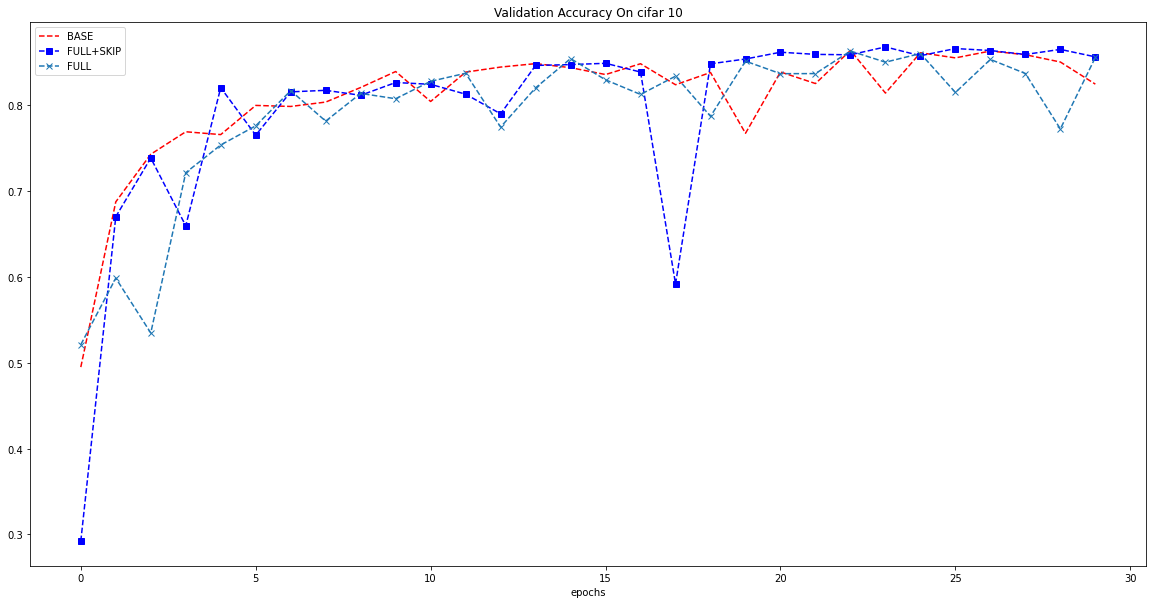

In [46]:
import matplotlib.pyplot as plt 
%matplotlib inline 
fig = plt.figure(figsize=(20,10))
plt.plot(BASE_cifar10.values.squeeze().tolist(), 'r--' )
plt.plot(FUll_Skip_cifar10.values.squeeze().tolist(), 'bs--')
plt.plot(FUll_cifar10.values.squeeze().tolist(), 'x--')
plt.title("Validation Accuracy On cifar 10")
plt.xlabel("epochs")
plt.legend(['BASE', 'FULL+SKIP', 'FULL'], )
plt.show()
 

In [48]:
import os, csv 
def write_file(filename, data, name='/train'):
    if not os.path.exists(filename):
        os.makedirs(filename)
    with open(filename+name+'.csv', mode='a') as file:
        time_writer = csv.writer(file, delimiter=',')
        time_writer.writerow(data)